In [7]:
from __future__ import division
import os
import urllib, cStringIO
import pymongo as pm ## first establish ssh tunnel to server where database is running
import base64
import numpy as np
from numpy import *
import PIL
from PIL import Image
import base64
import matplotlib
%matplotlib inline
from matplotlib import pylab, mlab, pyplot
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import seaborn as sns
sns.set_context('poster')
sns.set_style('white')
from matplotlib.path import Path
import matplotlib.patches as patches
import cv2
import pandas as pd
from svgpathtools import parse_path
import svg_distance_helpers as rsh
import svg_render_helpers as rrh

#### directory and file hierarchy

In [8]:
# directory & file hierarchy
analysis_dir = os.getcwd()
tracing_ref_pixel = os.path.join(analysis_dir, 'tracing_ref_pixel')
tracing_ref_svg = os.path.join(analysis_dir, 'tracing_ref_svg')
data_dir = os.path.join(analysis_dir,"trace_test")

canvas_side = 432 # image size
rows, cols = canvas_side, canvas_side # the size of a given drawing image

In [9]:
# set vars 
auth = pd.read_csv('auth.txt', header = None) # this auth.txt file contains the password for the sketchloop user
pswd = auth.values[0][0]
user = 'sketchloop'
host = 'rxdhawkins.me' ## cocolab ip address

# have to fix this to be able to analyze from local
import pymongo as pm
conn = pm.MongoClient('mongodb://sketchloop:' + pswd + '@127.0.0.1')
db = conn['kiddraw']
coll = db['cdm_run_v3']

IOError: File auth.txt does not exist

#### Get SVG data

In [ ]:
# test on a specific square with one stroke
imrecs = coll.find({'$and':[{'category':'square'},{'dataType':'finalImage'}, {'sessionId':'cdm_run_v31525889224904'}]}).sort('time')
print imrecs.count()

## retrieve example square tracing from db
imrec = imrecs[0] 

In [ ]:
reload(rsh)
## get list of vertices and codes for tracing 
try:
    ## get the corresponding stroke records for this tracing
    stroke_recs = coll.find({'$and': [{'sessionId':imrec['sessionId']}, 
                                      {'dataType':'stroke'},
                                      {'trialNum': imrec['trialNum']}]}).sort('time')

    print 'Number of strokes in this tracing: {}'.format(stroke_recs.count())    
    
    ## check to make sure that there is at least one stroke! 
    if stroke_recs.count()>0:

        ## now make an svg list!
        svg_list = rsh.make_svg_list(stroke_recs)

        ## get verts and codes in all strokes
        ## both verts_list and codes_list are 2D list. Each sublist represent a stroke
        verts_list, codes_list = rsh.get_verts_and_codes(svg_list)
        
        ## Convert multiple strokes into one stroke
        
        
except Exception as e:
    print 'Oops, something went wrong! Here is the error:'  
    print e
    pass        

#### Tracing/Copying Error Calculation 

In [4]:
# change names. only for testing purpose
for index, imgfile in enumerate(os.listdir(data_dir)):
    new_filename = 'test{:02}.png'.format(index)
    os.rename(os.path.join(data_dir,imgfile), os.path.join(data_dir,new_filename))

In [200]:
reload(rsh)
# get tracings from the data folder
#for file in os.listdir(data_dir):

# read in tracing and reference files
fpath = os.path.join(data_dir, 'test40.png')
img_draw = cv2.imread(fpath)
img_draw = cv2.resize(rsh.white_color_to_num(img_draw), (50, 50))
print len(rsh.find_black_pixels(img_draw))

square_ref_file = os.path.join(tracing_ref_pixel, 'square_50.png')
img_ref = cv2.imread(square_ref_file)
img_ref = rsh.black_color_to_num(img_ref)
print len(rsh.find_black_pixels(img_ref))


60
84


In [203]:
reload(rsh)
loss, final_draw, product, weights, bias = rsh.minimize_error_soft_index(img_ref, img_draw)
print loss
print weights
print bias

weight bias Parameter containing:
tensor([[1., 0.],
        [0., 1.]], requires_grad=True) Parameter containing:
tensor([0., 0.], requires_grad=True)
loss tensor(-0.0076)
weight bias Parameter containing:
tensor([[ 1.0000, -0.0000],
        [ 0.0000,  1.0000]], requires_grad=True) Parameter containing:
tensor([-1.6051e-07,  4.8131e-07], requires_grad=True)
loss tensor(-0.0076)
weight bias Parameter containing:
tensor([[ 1.0000, -0.0000],
        [ 0.0000,  1.0000]], requires_grad=True) Parameter containing:
tensor([-3.0208e-07,  9.7183e-07], requires_grad=True)
loss tensor(-0.0076)
weight bias Parameter containing:
tensor([[ 1.0000, -0.0000],
        [ 0.0000,  0.9999]], requires_grad=True) Parameter containing:
tensor([-4.5274e-07,  1.4432e-06], requires_grad=True)
loss tensor(-0.0076)
weight bias Parameter containing:
tensor([[ 1.0000, -0.0000],
        [ 0.0001,  0.9999]], requires_grad=True) Parameter containing:
tensor([-6.1283e-07,  1.8921e-06], requires_grad=True)
loss tensor(-0

loss tensor(-0.0048)
weight bias Parameter containing:
tensor([[ 0.9997, -0.0003],
        [-0.0333,  0.9641]], requires_grad=True) Parameter containing:
tensor([-0.0000, -0.0010], requires_grad=True)
loss tensor(-0.0048)
weight bias Parameter containing:
tensor([[ 0.9997, -0.0003],
        [-0.0334,  0.9642]], requires_grad=True) Parameter containing:
tensor([-0.0000, -0.0011], requires_grad=True)
loss tensor(-0.0048)
weight bias Parameter containing:
tensor([[ 0.9997, -0.0003],
        [-0.0334,  0.9643]], requires_grad=True) Parameter containing:
tensor([-0.0000, -0.0011], requires_grad=True)
loss tensor(-0.0048)
weight bias Parameter containing:
tensor([[ 0.9997, -0.0003],
        [-0.0335,  0.9643]], requires_grad=True) Parameter containing:
tensor([-0.0000, -0.0011], requires_grad=True)
loss tensor(-0.0048)
weight bias Parameter containing:
tensor([[ 0.9997, -0.0003],
        [-0.0336,  0.9644]], requires_grad=True) Parameter containing:
tensor([-0.0000, -0.0011], requires_grad=T

loss tensor(-0.0048)
weight bias Parameter containing:
tensor([[ 0.9997, -0.0003],
        [-0.0363,  0.9671]], requires_grad=True) Parameter containing:
tensor([-0.0000, -0.0012], requires_grad=True)
loss tensor(-0.0048)
weight bias Parameter containing:
tensor([[ 0.9997, -0.0003],
        [-0.0364,  0.9671]], requires_grad=True) Parameter containing:
tensor([-0.0000, -0.0012], requires_grad=True)
loss tensor(-0.0048)
weight bias Parameter containing:
tensor([[ 0.9997, -0.0003],
        [-0.0365,  0.9672]], requires_grad=True) Parameter containing:
tensor([-0.0000, -0.0012], requires_grad=True)
loss tensor(-0.0048)
weight bias Parameter containing:
tensor([[ 0.9997, -0.0003],
        [-0.0365,  0.9673]], requires_grad=True) Parameter containing:
tensor([-0.0000, -0.0012], requires_grad=True)
loss tensor(-0.0048)
weight bias Parameter containing:
tensor([[ 0.9997, -0.0003],
        [-0.0366,  0.9673]], requires_grad=True) Parameter containing:
tensor([-0.0000, -0.0012], requires_grad=T

loss tensor(-0.0049)
weight bias Parameter containing:
tensor([[ 0.9998, -0.0003],
        [-0.0397,  0.9704]], requires_grad=True) Parameter containing:
tensor([-0.0000, -0.0013], requires_grad=True)
loss tensor(-0.0049)
weight bias Parameter containing:
tensor([[ 0.9998, -0.0003],
        [-0.0397,  0.9704]], requires_grad=True) Parameter containing:
tensor([-0.0000, -0.0013], requires_grad=True)
loss tensor(-0.0049)
weight bias Parameter containing:
tensor([[ 0.9998, -0.0003],
        [-0.0398,  0.9705]], requires_grad=True) Parameter containing:
tensor([-0.0000, -0.0013], requires_grad=True)
loss tensor(-0.0049)
weight bias Parameter containing:
tensor([[ 0.9998, -0.0003],
        [-0.0399,  0.9706]], requires_grad=True) Parameter containing:
tensor([-0.0000, -0.0013], requires_grad=True)
loss tensor(-0.0049)
weight bias Parameter containing:
tensor([[ 0.9998, -0.0003],
        [-0.0399,  0.9706]], requires_grad=True) Parameter containing:
tensor([-0.0000, -0.0013], requires_grad=T

weight bias Parameter containing:
tensor([[ 0.9998, -0.0003],
        [-0.0449,  0.9756]], requires_grad=True) Parameter containing:
tensor([-0.0000, -0.0014], requires_grad=True)
loss tensor(-0.0049)
weight bias Parameter containing:
tensor([[ 0.9998, -0.0003],
        [-0.0450,  0.9757]], requires_grad=True) Parameter containing:
tensor([-0.0000, -0.0014], requires_grad=True)
loss tensor(-0.0049)
weight bias Parameter containing:
tensor([[ 0.9998, -0.0003],
        [-0.0451,  0.9758]], requires_grad=True) Parameter containing:
tensor([-0.0000, -0.0014], requires_grad=True)
loss tensor(-0.0049)
weight bias Parameter containing:
tensor([[ 0.9998, -0.0003],
        [-0.0452,  0.9759]], requires_grad=True) Parameter containing:
tensor([-0.0000, -0.0014], requires_grad=True)
loss tensor(-0.0049)
weight bias Parameter containing:
tensor([[ 0.9998, -0.0003],
        [-0.0452,  0.9759]], requires_grad=True) Parameter containing:
tensor([-0.0000, -0.0014], requires_grad=True)
loss tensor(-0.0

        [-0.0511,  0.9819]], requires_grad=True) Parameter containing:
tensor([-0.0000, -0.0016], requires_grad=True)
loss tensor(-0.0049)
weight bias Parameter containing:
tensor([[ 0.9998, -0.0002],
        [-0.0512,  0.9820]], requires_grad=True) Parameter containing:
tensor([-0.0000, -0.0016], requires_grad=True)
loss tensor(-0.0049)
weight bias Parameter containing:
tensor([[ 0.9998, -0.0002],
        [-0.0513,  0.9821]], requires_grad=True) Parameter containing:
tensor([-0.0000, -0.0016], requires_grad=True)
loss tensor(-0.0049)
weight bias Parameter containing:
tensor([[ 0.9998, -0.0002],
        [-0.0514,  0.9822]], requires_grad=True) Parameter containing:
tensor([-0.0000, -0.0016], requires_grad=True)
loss tensor(-0.0049)
weight bias Parameter containing:
tensor([[ 0.9998, -0.0002],
        [-0.0515,  0.9823]], requires_grad=True) Parameter containing:
tensor([-0.0000, -0.0016], requires_grad=True)
loss tensor(-0.0049)
weight bias Parameter containing:
tensor([[ 0.9998, -0.00

        [-0.0567,  0.9867]], requires_grad=True) Parameter containing:
tensor([-0.0000, -0.0018], requires_grad=True)
loss tensor(-0.0049)
weight bias Parameter containing:
tensor([[ 0.9999, -0.0002],
        [-0.0552,  0.9882]], requires_grad=True) Parameter containing:
tensor([-0.0000, -0.0017], requires_grad=True)
loss tensor(-0.0049)
weight bias Parameter containing:
tensor([[ 0.9999, -0.0002],
        [-0.0568,  0.9868]], requires_grad=True) Parameter containing:
tensor([-0.0000, -0.0018], requires_grad=True)
loss tensor(-0.0049)
weight bias Parameter containing:
tensor([[ 0.9999, -0.0002],
        [-0.0554,  0.9884]], requires_grad=True) Parameter containing:
tensor([-0.0000, -0.0017], requires_grad=True)
loss tensor(-0.0049)
weight bias Parameter containing:
tensor([[ 0.9999, -0.0002],
        [-0.0570,  0.9870]], requires_grad=True) Parameter containing:
tensor([-0.0000, -0.0018], requires_grad=True)
loss tensor(-0.0049)
weight bias Parameter containing:
tensor([[ 0.9999, -0.00

weight bias Parameter containing:
tensor([[ 0.9999, -0.0002],
        [-0.0593,  0.9940]], requires_grad=True) Parameter containing:
tensor([-0.0000, -0.0018], requires_grad=True)
loss tensor(-0.0049)
weight bias Parameter containing:
tensor([[ 0.9999, -0.0002],
        [-0.0603,  0.9934]], requires_grad=True) Parameter containing:
tensor([-0.0000, -0.0018], requires_grad=True)
loss tensor(-0.0049)
weight bias Parameter containing:
tensor([[ 0.9999, -0.0002],
        [-0.0619,  0.9922]], requires_grad=True) Parameter containing:
tensor([-0.0000, -0.0018], requires_grad=True)
loss tensor(-0.0049)
weight bias Parameter containing:
tensor([[ 0.9999, -0.0002],
        [-0.0595,  0.9945]], requires_grad=True) Parameter containing:
tensor([-0.0000, -0.0018], requires_grad=True)
loss tensor(-0.0049)
weight bias Parameter containing:
tensor([[ 0.9999, -0.0002],
        [-0.0601,  0.9944]], requires_grad=True) Parameter containing:
tensor([-0.0000, -0.0018], requires_grad=True)
loss tensor(-0.0

weight bias Parameter containing:
tensor([[ 0.9994, -0.0008],
        [-0.0448,  0.9697]], requires_grad=True) Parameter containing:
tensor([-0.0000, -0.0001], requires_grad=True)
loss tensor(-0.0049)
weight bias Parameter containing:
tensor([[ 0.9994, -0.0008],
        [-0.0447,  0.9697]], requires_grad=True) Parameter containing:
tensor([-0.0000, -0.0001], requires_grad=True)
loss tensor(-0.0049)
weight bias Parameter containing:
tensor([[ 0.9994, -0.0008],
        [-0.0447,  0.9696]], requires_grad=True) Parameter containing:
tensor([-0.0000, -0.0001], requires_grad=True)
loss tensor(-0.0049)
weight bias Parameter containing:
tensor([[ 0.9994, -0.0008],
        [-0.0447,  0.9696]], requires_grad=True) Parameter containing:
tensor([-0.0000, -0.0001], requires_grad=True)
loss tensor(-0.0049)
weight bias Parameter containing:
tensor([[ 0.9994, -0.0008],
        [-0.0446,  0.9695]], requires_grad=True) Parameter containing:
tensor([-0.0000, -0.0001], requires_grad=True)
loss tensor(-0.0

loss tensor(-0.0049)
weight bias Parameter containing:
tensor([[ 0.9996, -0.0007],
        [-0.0425,  0.9672]], requires_grad=True) Parameter containing:
tensor([-0.0000, -0.0002], requires_grad=True)
loss tensor(-0.0049)
weight bias Parameter containing:
tensor([[ 0.9996, -0.0007],
        [-0.0425,  0.9671]], requires_grad=True) Parameter containing:
tensor([-0.0000, -0.0002], requires_grad=True)
loss tensor(-0.0049)
weight bias Parameter containing:
tensor([[ 0.9996, -0.0007],
        [-0.0425,  0.9671]], requires_grad=True) Parameter containing:
tensor([-0.0000, -0.0002], requires_grad=True)
loss tensor(-0.0049)
weight bias Parameter containing:
tensor([[ 0.9996, -0.0007],
        [-0.0424,  0.9671]], requires_grad=True) Parameter containing:
tensor([-0.0000, -0.0002], requires_grad=True)
loss tensor(-0.0049)
weight bias Parameter containing:
tensor([[ 0.9996, -0.0007],
        [-0.0424,  0.9671]], requires_grad=True) Parameter containing:
tensor([-0.0000, -0.0002], requires_grad=T

loss tensor(-0.0049)
weight bias Parameter containing:
tensor([[ 0.9997, -0.0006],
        [-0.0413,  0.9658]], requires_grad=True) Parameter containing:
tensor([-0.0000, -0.0004], requires_grad=True)
loss tensor(-0.0049)
weight bias Parameter containing:
tensor([[ 0.9997, -0.0006],
        [-0.0413,  0.9658]], requires_grad=True) Parameter containing:
tensor([-0.0000, -0.0004], requires_grad=True)
loss tensor(-0.0049)
weight bias Parameter containing:
tensor([[ 0.9997, -0.0006],
        [-0.0413,  0.9658]], requires_grad=True) Parameter containing:
tensor([-0.0000, -0.0004], requires_grad=True)
loss tensor(-0.0049)
weight bias Parameter containing:
tensor([[ 0.9997, -0.0006],
        [-0.0412,  0.9658]], requires_grad=True) Parameter containing:
tensor([-0.0000, -0.0004], requires_grad=True)
loss tensor(-0.0049)
weight bias Parameter containing:
tensor([[ 0.9997, -0.0006],
        [-0.0412,  0.9658]], requires_grad=True) Parameter containing:
tensor([-0.0000, -0.0004], requires_grad=T

loss tensor(-0.0049)
weight bias Parameter containing:
tensor([[ 0.9997, -0.0006],
        [-0.0408,  0.9652]], requires_grad=True) Parameter containing:
tensor([-0.0000, -0.0005], requires_grad=True)
loss tensor(-0.0049)
weight bias Parameter containing:
tensor([[ 0.9997, -0.0006],
        [-0.0408,  0.9652]], requires_grad=True) Parameter containing:
tensor([-0.0000, -0.0005], requires_grad=True)
loss tensor(-0.0049)
weight bias Parameter containing:
tensor([[ 0.9997, -0.0006],
        [-0.0408,  0.9652]], requires_grad=True) Parameter containing:
tensor([-0.0000, -0.0005], requires_grad=True)
loss tensor(-0.0049)
weight bias Parameter containing:
tensor([[ 0.9997, -0.0006],
        [-0.0408,  0.9652]], requires_grad=True) Parameter containing:
tensor([-0.0000, -0.0005], requires_grad=True)
loss tensor(-0.0049)
weight bias Parameter containing:
tensor([[ 0.9997, -0.0006],
        [-0.0408,  0.9652]], requires_grad=True) Parameter containing:
tensor([-0.0000, -0.0005], requires_grad=T

weight bias Parameter containing:
tensor([[ 0.9997, -0.0006],
        [-0.0405,  0.9649]], requires_grad=True) Parameter containing:
tensor([-0.0000, -0.0005], requires_grad=True)
loss tensor(-0.0049)
weight bias Parameter containing:
tensor([[ 0.9997, -0.0006],
        [-0.0405,  0.9649]], requires_grad=True) Parameter containing:
tensor([-0.0000, -0.0005], requires_grad=True)
loss tensor(-0.0049)
weight bias Parameter containing:
tensor([[ 0.9998, -0.0006],
        [-0.0404,  0.9649]], requires_grad=True) Parameter containing:
tensor([-0.0000, -0.0005], requires_grad=True)
loss tensor(-0.0049)
weight bias Parameter containing:
tensor([[ 0.9998, -0.0006],
        [-0.0404,  0.9649]], requires_grad=True) Parameter containing:
tensor([-0.0000, -0.0005], requires_grad=True)
loss tensor(-0.0049)
weight bias Parameter containing:
tensor([[ 0.9998, -0.0006],
        [-0.0404,  0.9649]], requires_grad=True) Parameter containing:
tensor([-0.0000, -0.0005], requires_grad=True)
loss tensor(-0.0

        [-0.0402,  0.9646]], requires_grad=True) Parameter containing:
tensor([-0.0000, -0.0006], requires_grad=True)
loss tensor(-0.0049)
weight bias Parameter containing:
tensor([[ 0.9998, -0.0005],
        [-0.0402,  0.9646]], requires_grad=True) Parameter containing:
tensor([-0.0000, -0.0006], requires_grad=True)
loss tensor(-0.0049)
weight bias Parameter containing:
tensor([[ 0.9998, -0.0005],
        [-0.0402,  0.9646]], requires_grad=True) Parameter containing:
tensor([-0.0000, -0.0006], requires_grad=True)
loss tensor(-0.0049)
weight bias Parameter containing:
tensor([[ 0.9998, -0.0005],
        [-0.0402,  0.9646]], requires_grad=True) Parameter containing:
tensor([-0.0000, -0.0006], requires_grad=True)
loss tensor(-0.0049)
weight bias Parameter containing:
tensor([[ 0.9998, -0.0005],
        [-0.0402,  0.9646]], requires_grad=True) Parameter containing:
tensor([-0.0000, -0.0006], requires_grad=True)
loss tensor(-0.0049)
weight bias Parameter containing:
tensor([[ 0.9998, -0.00

loss tensor(-0.0049)
weight bias Parameter containing:
tensor([[ 0.9998, -0.0005],
        [-0.0400,  0.9644]], requires_grad=True) Parameter containing:
tensor([-0.0000, -0.0007], requires_grad=True)
loss tensor(-0.0049)
weight bias Parameter containing:
tensor([[ 0.9998, -0.0005],
        [-0.0400,  0.9644]], requires_grad=True) Parameter containing:
tensor([-0.0000, -0.0007], requires_grad=True)
loss tensor(-0.0049)
weight bias Parameter containing:
tensor([[ 0.9998, -0.0005],
        [-0.0400,  0.9644]], requires_grad=True) Parameter containing:
tensor([-0.0000, -0.0007], requires_grad=True)
loss tensor(-0.0049)
weight bias Parameter containing:
tensor([[ 0.9998, -0.0005],
        [-0.0400,  0.9644]], requires_grad=True) Parameter containing:
tensor([-0.0000, -0.0007], requires_grad=True)
loss tensor(-0.0049)
weight bias Parameter containing:
tensor([[ 0.9998, -0.0005],
        [-0.0400,  0.9644]], requires_grad=True) Parameter containing:
tensor([-0.0000, -0.0007], requires_grad=T

weight bias Parameter containing:
tensor([[ 0.9999, -0.0005],
        [-0.0399,  0.9642]], requires_grad=True) Parameter containing:
tensor([-0.0000, -0.0008], requires_grad=True)
loss tensor(-0.0049)
weight bias Parameter containing:
tensor([[ 0.9999, -0.0005],
        [-0.0399,  0.9642]], requires_grad=True) Parameter containing:
tensor([-0.0000, -0.0008], requires_grad=True)
loss tensor(-0.0049)
weight bias Parameter containing:
tensor([[ 0.9999, -0.0005],
        [-0.0399,  0.9642]], requires_grad=True) Parameter containing:
tensor([-0.0000, -0.0008], requires_grad=True)
loss tensor(-0.0049)
weight bias Parameter containing:
tensor([[ 0.9999, -0.0005],
        [-0.0399,  0.9642]], requires_grad=True) Parameter containing:
tensor([-0.0000, -0.0008], requires_grad=True)
loss tensor(-0.0049)
weight bias Parameter containing:
tensor([[ 0.9999, -0.0005],
        [-0.0399,  0.9642]], requires_grad=True) Parameter containing:
tensor([-0.0000, -0.0008], requires_grad=True)
loss tensor(-0.0

In [204]:
final = product.long().detach().numpy()


In [205]:
_final = final*255

In [206]:
im = Image.fromarray(np.uint8(_final))

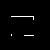

In [207]:
im

In [176]:
reload(rsh)
# ref = np.array([[0,0,0,1,0,0,1], [0,0,0,1,0,0,1], [0,0,0,1,0,0,1], [0,0,0,1,0,0,1]])
# draw = np.array([[0,0,0,1,0,0,1], [0,0,0,1,0,0,1], [0,0,0,1,0,0,1], [0,0,0,1,0,0,1]])

ref = np.array([[0,0,1],[0,0,1], [0,0,0]])
draw = np.array([[0,1,0],[0,1,0],[0,0,0]])

loss, final_draw, product, weights, bias = rsh.minimize_error_soft_index(draw, draw)
print weights
print bias
print product.long()
print final_draw

x tensor([[0., 1.],
        [1., 1.]])
x_prime tensor([[0., 1.],
        [1., 1.]], grad_fn=<ThAddmmBackward>)
img_draw after transformation tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 0, 0]])
product flat tensor([3.0073e-04, 1.0003e+00, 3.0073e-04, 3.0073e-04, 1.0003e+00, 3.0073e-04,
        9.0387e-08, 3.0065e-04, 9.0387e-08], grad_fn=<ViewBackward>)
ref flat tensor([0., 1., 0., 0., 1., 0., 0., 0., 0.])
loss tensor(-0.2223)
x_prime tensor([[0.0000, 1.0000],
        [1.0000, 1.0000]], grad_fn=<ThAddmmBackward>)
img_draw after transformation tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 0, 0]])
product flat tensor([3.0073e-04, 1.0003e+00, 3.0073e-04, 3.0073e-04, 1.0003e+00, 3.0073e-04,
        9.0333e-08, 3.0047e-04, 9.0333e-08], grad_fn=<ViewBackward>)
ref flat tensor([0., 1., 0., 0., 1., 0., 0., 0., 0.])
loss tensor(-0.2223)
x_prime tensor([[7.9357e-07, 1.0000e+00],
        [9.9991e-01, 1.0000e+00]], grad_fn=<ThAddmmBackward>)
img_draw after transformation tensor([[0, 1, 0]

        [ 0.9964,  1.0000]], grad_fn=<ThAddmmBackward>)
img_draw after transformation tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 0, 0]])
product flat tensor([3.0073e-04, 1.0003e+00, 3.0073e-04, 3.0073e-04, 1.0003e+00, 3.0073e-04,
        8.6170e-08, 2.8662e-04, 8.6170e-08], grad_fn=<ViewBackward>)
ref flat tensor([0., 1., 0., 0., 1., 0., 0., 0., 0.])
loss tensor(-0.2223)
x_prime tensor([[-0.0001,  1.0000],
        [ 0.9964,  1.0000]], grad_fn=<ThAddmmBackward>)
img_draw after transformation tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 0, 0]])
product flat tensor([3.0073e-04, 1.0003e+00, 3.0073e-04, 3.0073e-04, 1.0003e+00, 3.0073e-04,
        8.6114e-08, 2.8644e-04, 8.6114e-08], grad_fn=<ViewBackward>)
ref flat tensor([0., 1., 0., 0., 1., 0., 0., 0., 0.])
loss tensor(-0.2223)
x_prime tensor([[-0.0001,  1.0000],
        [ 0.9963,  1.0000]], grad_fn=<ThAddmmBackward>)
img_draw after transformation tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 0, 0]])
product flat tensor([3

product flat tensor([3.0074e-04, 1.0003e+00, 3.0074e-04, 3.0073e-04, 1.0003e+00, 3.0073e-04,
        8.2715e-08, 2.7513e-04, 8.2715e-08], grad_fn=<ViewBackward>)
ref flat tensor([0., 1., 0., 0., 1., 0., 0., 0., 0.])
loss tensor(-0.2223)
x_prime tensor([[-0.0004,  1.0000],
        [ 0.9933,  1.0000]], grad_fn=<ThAddmmBackward>)
img_draw after transformation tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 0, 0]])
product flat tensor([3.0074e-04, 1.0003e+00, 3.0074e-04, 3.0073e-04, 1.0003e+00, 3.0073e-04,
        8.2654e-08, 2.7493e-04, 8.2654e-08], grad_fn=<ViewBackward>)
ref flat tensor([0., 1., 0., 0., 1., 0., 0., 0., 0.])
loss tensor(-0.2223)
x_prime tensor([[-0.0004,  1.0000],
        [ 0.9932,  1.0000]], grad_fn=<ThAddmmBackward>)
img_draw after transformation tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 0, 0]])
product flat tensor([3.0074e-04, 1.0003e+00, 3.0074e-04, 3.0073e-04, 1.0003e+00, 3.0073e-04,
        8.2593e-08, 2.7473e-04, 8.2593e-08], grad_fn=<ViewBackward>)
ref 

img_draw after transformation tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 0, 0]])
product flat tensor([3.0074e-04, 1.0003e+00, 3.0074e-04, 3.0073e-04, 1.0003e+00, 3.0073e-04,
        7.8768e-08, 2.6200e-04, 7.8768e-08], grad_fn=<ViewBackward>)
ref flat tensor([0., 1., 0., 0., 1., 0., 0., 0., 0.])
loss tensor(-0.2223)
x_prime tensor([[-0.0010,  1.0000],
        [ 0.9896,  1.0000]], grad_fn=<ThAddmmBackward>)
img_draw after transformation tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 0, 0]])
product flat tensor([3.0074e-04, 1.0003e+00, 3.0074e-04, 3.0073e-04, 1.0003e+00, 3.0073e-04,
        7.8702e-08, 2.6178e-04, 7.8702e-08], grad_fn=<ViewBackward>)
ref flat tensor([0., 1., 0., 0., 1., 0., 0., 0., 0.])
loss tensor(-0.2223)
x_prime tensor([[-0.0010,  1.0000],
        [ 0.9895,  1.0000]], grad_fn=<ThAddmmBackward>)
img_draw after transformation tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 0, 0]])
product flat tensor([3.0074e-04, 1.0003e+00, 3.0074e-04, 3.0073e-04, 1.0003e+0

img_draw after transformation tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 0, 0]])
product flat tensor([3.0075e-04, 1.0004e+00, 3.0075e-04, 3.0073e-04, 1.0003e+00, 3.0073e-04,
        7.4956e-08, 2.4932e-04, 7.4956e-08], grad_fn=<ViewBackward>)
ref flat tensor([0., 1., 0., 0., 1., 0., 0., 0., 0.])
loss tensor(-0.2223)
x_prime tensor([[-0.0019,  1.0000],
        [ 0.9858,  1.0000]], grad_fn=<ThAddmmBackward>)
img_draw after transformation tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 0, 0]])
product flat tensor([3.0075e-04, 1.0004e+00, 3.0075e-04, 3.0073e-04, 1.0003e+00, 3.0073e-04,
        7.4884e-08, 2.4908e-04, 7.4884e-08], grad_fn=<ViewBackward>)
ref flat tensor([0., 1., 0., 0., 1., 0., 0., 0., 0.])
loss tensor(-0.2223)
x_prime tensor([[-0.0019,  1.0000],
        [ 0.9857,  1.0000]], grad_fn=<ThAddmmBackward>)
img_draw after transformation tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 0, 0]])
product flat tensor([3.0075e-04, 1.0004e+00, 3.0075e-04, 3.0073e-04, 1.0003e+0

product flat tensor([3.0075e-04, 1.0004e+00, 3.0075e-04, 3.0072e-04, 1.0003e+00, 3.0072e-04,
        7.0338e-08, 2.3396e-04, 7.0338e-08], grad_fn=<ViewBackward>)
ref flat tensor([0., 1., 0., 0., 1., 0., 0., 0., 0.])
loss tensor(-0.2223)
x_prime tensor([[-0.0033,  1.0000],
        [ 0.9810,  1.0000]], grad_fn=<ThAddmmBackward>)
img_draw after transformation tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 0, 0]])
product flat tensor([3.0075e-04, 1.0004e+00, 3.0075e-04, 3.0072e-04, 1.0003e+00, 3.0072e-04,
        7.0259e-08, 2.3370e-04, 7.0259e-08], grad_fn=<ViewBackward>)
ref flat tensor([0., 1., 0., 0., 1., 0., 0., 0., 0.])
loss tensor(-0.2223)
x_prime tensor([[-0.0034,  1.0000],
        [ 0.9809,  1.0000]], grad_fn=<ThAddmmBackward>)
img_draw after transformation tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 0, 0]])
product flat tensor([3.0075e-04, 1.0004e+00, 3.0075e-04, 3.0072e-04, 1.0003e+00, 3.0072e-04,
        7.0179e-08, 2.3343e-04, 7.0179e-08], grad_fn=<ViewBackward>)
ref 

x_prime tensor([[-0.0054,  1.0000],
        [ 0.9754,  1.0000]], grad_fn=<ThAddmmBackward>)
img_draw after transformation tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 0, 0]])
product flat tensor([3.0076e-04, 1.0004e+00, 3.0076e-04, 3.0072e-04, 1.0003e+00, 3.0072e-04,
        6.5257e-08, 2.1706e-04, 6.5257e-08], grad_fn=<ViewBackward>)
ref flat tensor([0., 1., 0., 0., 1., 0., 0., 0., 0.])
loss tensor(-0.2223)
x_prime tensor([[-0.0054,  1.0000],
        [ 0.9753,  1.0000]], grad_fn=<ThAddmmBackward>)
img_draw after transformation tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 0, 0]])
product flat tensor([3.0076e-04, 1.0004e+00, 3.0076e-04, 3.0072e-04, 1.0003e+00, 3.0072e-04,
        6.5170e-08, 2.1677e-04, 6.5170e-08], grad_fn=<ViewBackward>)
ref flat tensor([0., 1., 0., 0., 1., 0., 0., 0., 0.])
loss tensor(-0.2223)
x_prime tensor([[-0.0055,  1.0000],
        [ 0.9752,  1.0000]], grad_fn=<ThAddmmBackward>)
img_draw after transformation tensor([[0, 1, 0],
        [0, 1, 0],
      

img_draw after transformation tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 0, 0]])
product flat tensor([3.0077e-04, 1.0005e+00, 3.0077e-04, 3.0072e-04, 1.0003e+00, 3.0072e-04,
        6.0136e-08, 2.0003e-04, 6.0136e-08], grad_fn=<ViewBackward>)
ref flat tensor([0., 1., 0., 0., 1., 0., 0., 0., 0.])
loss tensor(-0.2223)
x_prime tensor([[-0.0081,  1.0000],
        [ 0.9690,  1.0000]], grad_fn=<ThAddmmBackward>)
img_draw after transformation tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 0, 0]])
product flat tensor([3.0078e-04, 1.0005e+00, 3.0078e-04, 3.0072e-04, 1.0003e+00, 3.0072e-04,
        6.0040e-08, 1.9971e-04, 6.0040e-08], grad_fn=<ViewBackward>)
ref flat tensor([0., 1., 0., 0., 1., 0., 0., 0., 0.])
loss tensor(-0.2223)
x_prime tensor([[-0.0081,  1.0000],
        [ 0.9689,  1.0000]], grad_fn=<ThAddmmBackward>)
img_draw after transformation tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 0, 0]])
product flat tensor([3.0078e-04, 1.0005e+00, 3.0078e-04, 3.0072e-04, 1.0003e+0

loss tensor(-0.2223)
x_prime tensor([[-0.0118,  1.0000],
        [ 0.9610,  1.0000]], grad_fn=<ThAddmmBackward>)
img_draw after transformation tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 0, 0]])
product flat tensor([3.0079e-04, 1.0005e+00, 3.0079e-04, 3.0071e-04, 1.0003e+00, 3.0071e-04,
        5.4113e-08, 1.7999e-04, 5.4113e-08], grad_fn=<ViewBackward>)
ref flat tensor([0., 1., 0., 0., 1., 0., 0., 0., 0.])
loss tensor(-0.2223)
x_prime tensor([[-0.0119,  1.0000],
        [ 0.9609,  1.0000]], grad_fn=<ThAddmmBackward>)
img_draw after transformation tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 0, 0]])
product flat tensor([3.0079e-04, 1.0005e+00, 3.0079e-04, 3.0071e-04, 1.0003e+00, 3.0071e-04,
        5.4008e-08, 1.7964e-04, 5.4008e-08], grad_fn=<ViewBackward>)
ref flat tensor([0., 1., 0., 0., 1., 0., 0., 0., 0.])
loss tensor(-0.2223)
x_prime tensor([[-0.0120,  1.0000],
        [ 0.9607,  1.0000]], grad_fn=<ThAddmmBackward>)
img_draw after transformation tensor([[0, 1, 0],
    

loss tensor(-0.2223)
x_prime tensor([[-0.0173,  1.0000],
        [ 0.9506,  1.0000]], grad_fn=<ThAddmmBackward>)
img_draw after transformation tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 0, 0]])
product flat tensor([3.0081e-04, 1.0006e+00, 3.0081e-04, 3.0071e-04, 1.0002e+00, 3.0071e-04,
        4.7258e-08, 1.5719e-04, 4.7258e-08], grad_fn=<ViewBackward>)
ref flat tensor([0., 1., 0., 0., 1., 0., 0., 0., 0.])
loss tensor(-0.2223)
x_prime tensor([[-0.0174,  1.0000],
        [ 0.9504,  1.0000]], grad_fn=<ThAddmmBackward>)
img_draw after transformation tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 0, 0]])
product flat tensor([3.0081e-04, 1.0006e+00, 3.0081e-04, 3.0071e-04, 1.0002e+00, 3.0071e-04,
        4.7142e-08, 1.5681e-04, 4.7142e-08], grad_fn=<ViewBackward>)
ref flat tensor([0., 1., 0., 0., 1., 0., 0., 0., 0.])
loss tensor(-0.2223)
x_prime tensor([[-0.0175,  1.0000],
        [ 0.9502,  1.0000]], grad_fn=<ThAddmmBackward>)
img_draw after transformation tensor([[0, 1, 0],
    

x_prime tensor([[-0.0258,  1.0000],
        [ 0.9355,  1.0000]], grad_fn=<ThAddmmBackward>)
img_draw after transformation tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 0, 0]])
product flat tensor([3.0086e-04, 1.0007e+00, 3.0086e-04, 3.0070e-04, 1.0002e+00, 3.0070e-04,
        3.8949e-08, 1.2955e-04, 3.8949e-08], grad_fn=<ViewBackward>)
ref flat tensor([0., 1., 0., 0., 1., 0., 0., 0., 0.])
loss tensor(-0.2223)
x_prime tensor([[-0.0259,  1.0000],
        [ 0.9352,  1.0000]], grad_fn=<ThAddmmBackward>)
img_draw after transformation tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 0, 0]])
product flat tensor([3.0086e-04, 1.0007e+00, 3.0086e-04, 3.0070e-04, 1.0002e+00, 3.0070e-04,
        3.8820e-08, 1.2913e-04, 3.8820e-08], grad_fn=<ViewBackward>)
ref flat tensor([0., 1., 0., 0., 1., 0., 0., 0., 0.])
loss tensor(-0.2223)
x_prime tensor([[-0.0261,  1.0000],
        [ 0.9350,  1.0000]], grad_fn=<ThAddmmBackward>)
img_draw after transformation tensor([[0, 1, 0],
        [0, 1, 0],
      

loss tensor(-0.2223)
x_prime tensor([[-0.0339,  1.0000],
        [ 0.9218,  1.0000]], grad_fn=<ThAddmmBackward>)
img_draw after transformation tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 0, 0]])
product flat tensor([3.0090e-04, 1.0009e+00, 3.0090e-04, 3.0069e-04, 1.0002e+00, 3.0069e-04,
        3.2705e-08, 1.0879e-04, 3.2705e-08], grad_fn=<ViewBackward>)
ref flat tensor([0., 1., 0., 0., 1., 0., 0., 0., 0.])
loss tensor(-0.2223)
x_prime tensor([[-0.0341,  1.0000],
        [ 0.9214,  1.0000]], grad_fn=<ThAddmmBackward>)
img_draw after transformation tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 0, 0]])
product flat tensor([3.0090e-04, 1.0009e+00, 3.0090e-04, 3.0069e-04, 1.0002e+00, 3.0069e-04,
        3.2568e-08, 1.0833e-04, 3.2568e-08], grad_fn=<ViewBackward>)
ref flat tensor([0., 1., 0., 0., 1., 0., 0., 0., 0.])
loss tensor(-0.2223)
x_prime tensor([[-0.0343,  1.0000],
        [ 0.9211,  1.0000]], grad_fn=<ThAddmmBackward>)
img_draw after transformation tensor([[0, 1, 0],
    

img_draw after transformation tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 0, 0]])
product flat tensor([3.0101e-04, 1.0012e+00, 3.0101e-04, 3.0067e-04, 1.0001e+00, 3.0067e-04,
        2.4137e-08, 8.0284e-05, 2.4137e-08], grad_fn=<ViewBackward>)
ref flat tensor([0., 1., 0., 0., 1., 0., 0., 0., 0.])
loss tensor(-0.2224)
x_prime tensor([[-0.0493,  1.0000],
        [ 0.8971,  1.0000]], grad_fn=<ThAddmmBackward>)
img_draw after transformation tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 0, 0]])
product flat tensor([3.0101e-04, 1.0012e+00, 3.0101e-04, 3.0067e-04, 1.0001e+00, 3.0067e-04,
        2.3988e-08, 7.9790e-05, 2.3988e-08], grad_fn=<ViewBackward>)
ref flat tensor([0., 1., 0., 0., 1., 0., 0., 0., 0.])
loss tensor(-0.2224)
x_prime tensor([[-0.0496,  1.0000],
        [ 0.8966,  1.0000]], grad_fn=<ThAddmmBackward>)
img_draw after transformation tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 0, 0]])
product flat tensor([3.0101e-04, 1.0012e+00, 3.0101e-04, 3.0067e-04, 1.0001e+0

        [ 0.8802,  1.0000]], grad_fn=<ThAddmmBackward>)
img_draw after transformation tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 0, 0]])
product flat tensor([3.0111e-04, 1.0016e+00, 3.0111e-04, 3.0066e-04, 1.0001e+00, 3.0066e-04,
        1.9453e-08, 6.4707e-05, 1.9453e-08], grad_fn=<ViewBackward>)
ref flat tensor([0., 1., 0., 0., 1., 0., 0., 0., 0.])
loss tensor(-0.2224)
x_prime tensor([[-0.0605,  1.0000],
        [ 0.8796,  1.0000]], grad_fn=<ThAddmmBackward>)
img_draw after transformation tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 0, 0]])
product flat tensor([3.0112e-04, 1.0016e+00, 3.0112e-04, 3.0066e-04, 1.0001e+00, 3.0066e-04,
        1.9300e-08, 6.4195e-05, 1.9300e-08], grad_fn=<ViewBackward>)
ref flat tensor([0., 1., 0., 0., 1., 0., 0., 0., 0.])
loss tensor(-0.2224)
x_prime tensor([[-0.0609,  1.0000],
        [ 0.8789,  1.0000]], grad_fn=<ThAddmmBackward>)
img_draw after transformation tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 0, 0]])
product flat tensor([3

ref flat tensor([0., 1., 0., 0., 1., 0., 0., 0., 0.])
loss tensor(-0.2225)
x_prime tensor([[-0.0834,  1.0000],
        [ 0.8443,  1.0000]], grad_fn=<ThAddmmBackward>)
img_draw after transformation tensor([[0, 1, 0],
        [0, 0, 0],
        [0, 0, 0]])
product flat tensor([3.0144e-04, 1.0027e+00, 3.0144e-04, 3.0060e-04, 9.9988e-01, 3.0060e-04,
        1.2538e-08, 4.1706e-05, 1.2538e-08], grad_fn=<ViewBackward>)
ref flat tensor([0., 1., 0., 0., 1., 0., 0., 0., 0.])
loss tensor(-0.2225)
x_prime tensor([[-0.0841,  1.0000],
        [ 0.8432,  1.0000]], grad_fn=<ThAddmmBackward>)
img_draw after transformation tensor([[0, 1, 0],
        [0, 0, 0],
        [0, 0, 0]])
product flat tensor([3.0145e-04, 1.0027e+00, 3.0145e-04, 3.0060e-04, 9.9988e-01, 3.0060e-04,
        1.2378e-08, 4.1173e-05, 1.2378e-08], grad_fn=<ViewBackward>)
ref flat tensor([0., 1., 0., 0., 1., 0., 0., 0., 0.])
loss tensor(-0.2225)
x_prime tensor([[-0.0848,  1.0000],
        [ 0.8421,  1.0000]], grad_fn=<ThAddmmBackward>)

product flat tensor([3.0550e-04, 1.0162e+00, 3.0550e-04, 2.9892e-04, 9.9428e-01, 2.9892e-04,
        3.1950e-09, 1.0627e-05, 3.1950e-09], grad_fn=<ViewBackward>)
ref flat tensor([0., 1., 0., 0., 1., 0., 0., 0., 0.])
loss tensor(-0.2234)
x_prime tensor([[-0.1624,  1.0000],
        [ 0.7234,  1.0000]], grad_fn=<ThAddmmBackward>)
img_draw after transformation tensor([[0, 1, 0],
        [0, 0, 0],
        [0, 0, 0]])
product flat tensor([3.0579e-04, 1.0171e+00, 3.0579e-04, 2.9875e-04, 9.9372e-01, 2.9875e-04,
        3.0659e-09, 1.0198e-05, 3.0659e-09], grad_fn=<ViewBackward>)
ref flat tensor([0., 1., 0., 0., 1., 0., 0., 0., 0.])
loss tensor(-0.2234)
x_prime tensor([[-0.1649,  1.0000],
        [ 0.7197,  1.0000]], grad_fn=<ThAddmmBackward>)
img_draw after transformation tensor([[0, 1, 0],
        [0, 0, 0],
        [0, 0, 0]])
product flat tensor([3.0611e-04, 1.0182e+00, 3.0611e-04, 2.9856e-04, 9.9308e-01, 2.9856e-04,
        2.9396e-09, 9.7778e-06, 2.9396e-09], grad_fn=<ViewBackward>)
ref 

ref flat tensor([0., 1., 0., 0., 1., 0., 0., 0., 0.])
loss tensor(-0.2245)
x_prime tensor([[-0.2162,  1.0000],
        [ 0.6257,  1.0000]], grad_fn=<ThAddmmBackward>)
img_draw after transformation tensor([[0, 1, 0],
        [0, 0, 0],
        [0, 0, 0]])
product flat tensor([3.2601e-04, 1.0844e+00, 3.2601e-04, 2.8146e-04, 9.3622e-01, 2.8146e-04,
        1.0506e-09, 3.4944e-06, 1.0506e-09], grad_fn=<ViewBackward>)
ref flat tensor([0., 1., 0., 0., 1., 0., 0., 0., 0.])
loss tensor(-0.2245)
x_prime tensor([[-0.2160,  1.0000],
        [ 0.6256,  1.0000]], grad_fn=<ThAddmmBackward>)
img_draw after transformation tensor([[0, 1, 0],
        [0, 0, 0],
        [0, 0, 0]])
product flat tensor([3.2604e-04, 1.0845e+00, 3.2604e-04, 2.8144e-04, 9.3614e-01, 2.8144e-04,
        1.0499e-09, 3.4921e-06, 1.0499e-09], grad_fn=<ViewBackward>)
ref flat tensor([0., 1., 0., 0., 1., 0., 0., 0., 0.])
loss tensor(-0.2245)
x_prime tensor([[-0.2158,  1.0000],
        [ 0.6256,  1.0000]], grad_fn=<ThAddmmBackward>)

loss tensor(-0.2245)
x_prime tensor([[-0.2072,  1.0000],
        [ 0.6242,  1.0000]], grad_fn=<ThAddmmBackward>)
img_draw after transformation tensor([[0, 1, 0],
        [0, 0, 0],
        [0, 0, 0]])
product flat tensor([3.2674e-04, 1.0868e+00, 3.2674e-04, 2.8084e-04, 9.3413e-01, 2.8084e-04,
        1.0338e-09, 3.4387e-06, 1.0338e-09], grad_fn=<ViewBackward>)
ref flat tensor([0., 1., 0., 0., 1., 0., 0., 0., 0.])
loss tensor(-0.2245)
x_prime tensor([[-0.2070,  1.0000],
        [ 0.6241,  1.0000]], grad_fn=<ThAddmmBackward>)
img_draw after transformation tensor([[0, 1, 0],
        [0, 0, 0],
        [0, 0, 0]])
product flat tensor([3.2675e-04, 1.0869e+00, 3.2675e-04, 2.8082e-04, 9.3409e-01, 2.8082e-04,
        1.0335e-09, 3.4378e-06, 1.0335e-09], grad_fn=<ViewBackward>)
ref flat tensor([0., 1., 0., 0., 1., 0., 0., 0., 0.])
loss tensor(-0.2246)
x_prime tensor([[-0.2068,  1.0000],
        [ 0.6241,  1.0000]], grad_fn=<ThAddmmBackward>)
img_draw after transformation tensor([[0, 1, 0],
    

#### preprocessing of tracing and visualization (if desired)


In [ ]:
reallyRun = 1
if reallyRun:
    rsh.plot_shape(verts_list, codes_list, canvas_side)
    #rsh.plot_stroke(verts_list[1], codes_list[1], canvas_side)

#### Prepare human rating

In [59]:
data = pd.DataFrame(os.listdir(data_dir))
data.columns = ['image_id']
data.to_csv(os.path.join(analysis_dir,'performance.csv'))